# Лабораторная работа 2: Ансамблевые методы и бустинг

**Цель**: Предсказать выдачу кредита

**ROC-AUC >= 0.75**

## 1. Импорт

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, 
    precision_recall_curve, confusion_matrix
)
from sklearn.base import clone
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

## 2. EDA - Разведочный анализ данных


### 2.1 График целевой переменной


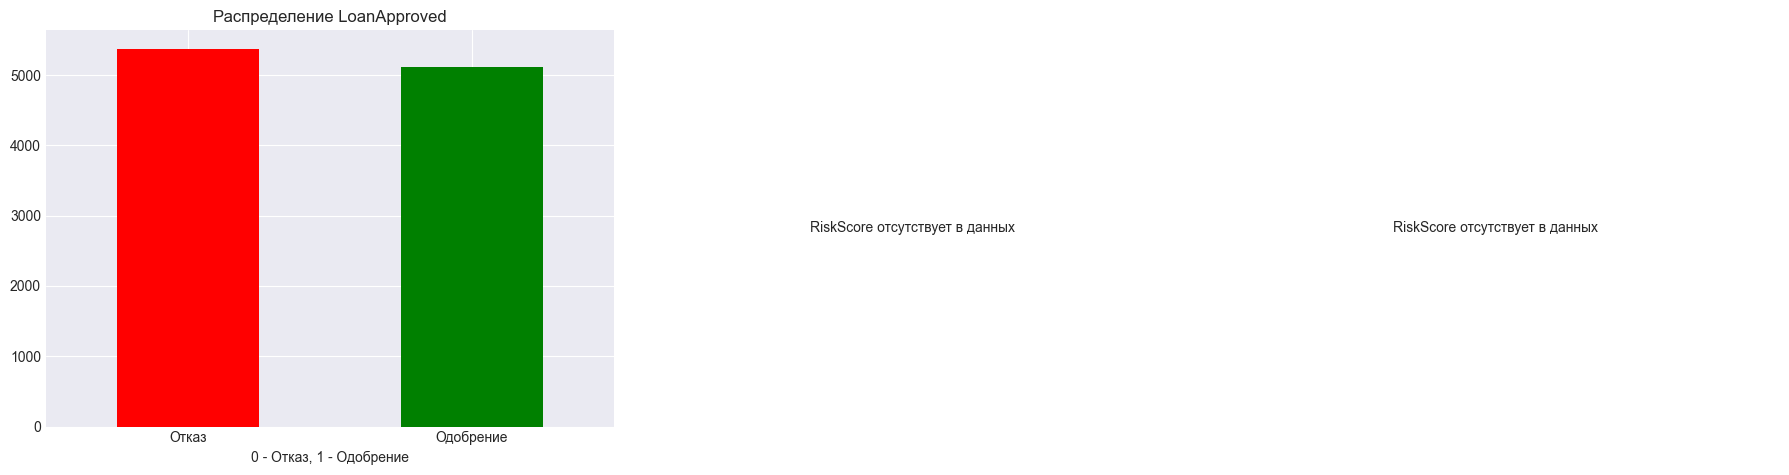


Train shape: (11017, 35)
Test shape: (5000, 35)
Train clean shape: (10487, 35)


In [2]:
train = pd.read_csv('datasets/train_c.csv')
test = pd.read_csv('datasets/test_c.csv')

train_clean = train.dropna(subset=['LoanApproved']).copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

train_clean['LoanApproved'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Распределение LoanApproved')
axes[0].set_xlabel('0 - Отказ, 1 - Одобрение')
axes[0].set_xticklabels(['Отказ', 'Одобрение'], rotation=0)

if 'RiskScore' in train_clean.columns:
    axes[1].hist(train_clean['RiskScore'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=50, color='red', linestyle='--', linewidth=2, label='Порог = 50')
    axes[1].set_xlabel('RiskScore')
    axes[1].set_ylabel('Частота')
    axes[1].set_title('Распределение RiskScore')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    train_clean.boxplot(column='RiskScore', by='LoanApproved', ax=axes[2])
    axes[2].set_title('RiskScore по классам')
    
    print(f"Средний RiskScore для одобренных: {train_clean[train_clean['LoanApproved']==1]['RiskScore'].mean():.2f}")
    print(f"Средний RiskScore для отказанных: {train_clean[train_clean['LoanApproved']==0]['RiskScore'].mean():.2f}")
else:
    axes[1].text(0.5, 0.5, 'RiskScore отсутствует в данных', ha='center', va='center')
    axes[1].axis('off')
    axes[2].text(0.5, 0.5, 'RiskScore отсутствует в данных', ha='center', va='center')
    axes[2].axis('off')

plt.suptitle('')
plt.tight_layout()
plt.show()

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train clean shape: {train_clean.shape}")


### 2.2 Зависимость признаков от целевой переменной

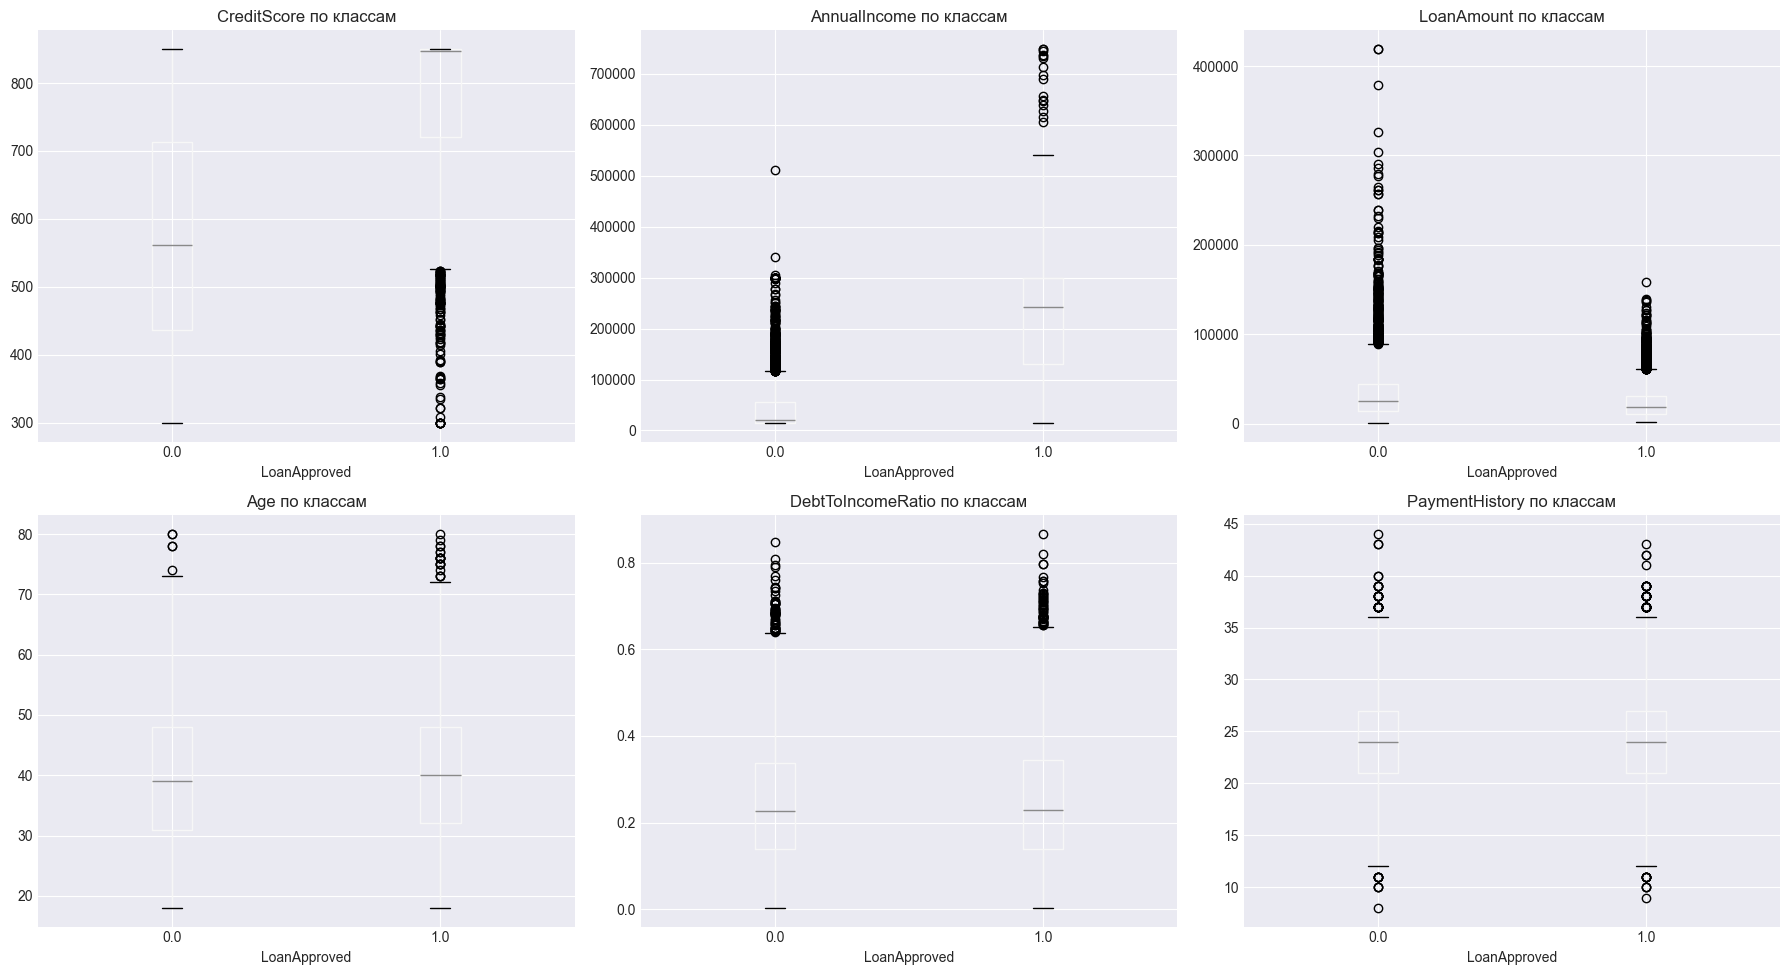

In [3]:
key_features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'Age', 'DebtToIncomeRatio', 'PaymentHistory']
valid_features = [f for f in key_features if f in train_clean.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(valid_features):
    data_clean = train_clean[[feature, 'LoanApproved']].dropna()
    data_clean.boxplot(column=feature, by='LoanApproved', ax=axes[idx])
    axes[idx].set_title(f'{feature} по классам')
    axes[idx].set_xlabel('LoanApproved')

plt.suptitle('')
plt.tight_layout()
plt.show()


### 2.3 Матрица корреляций


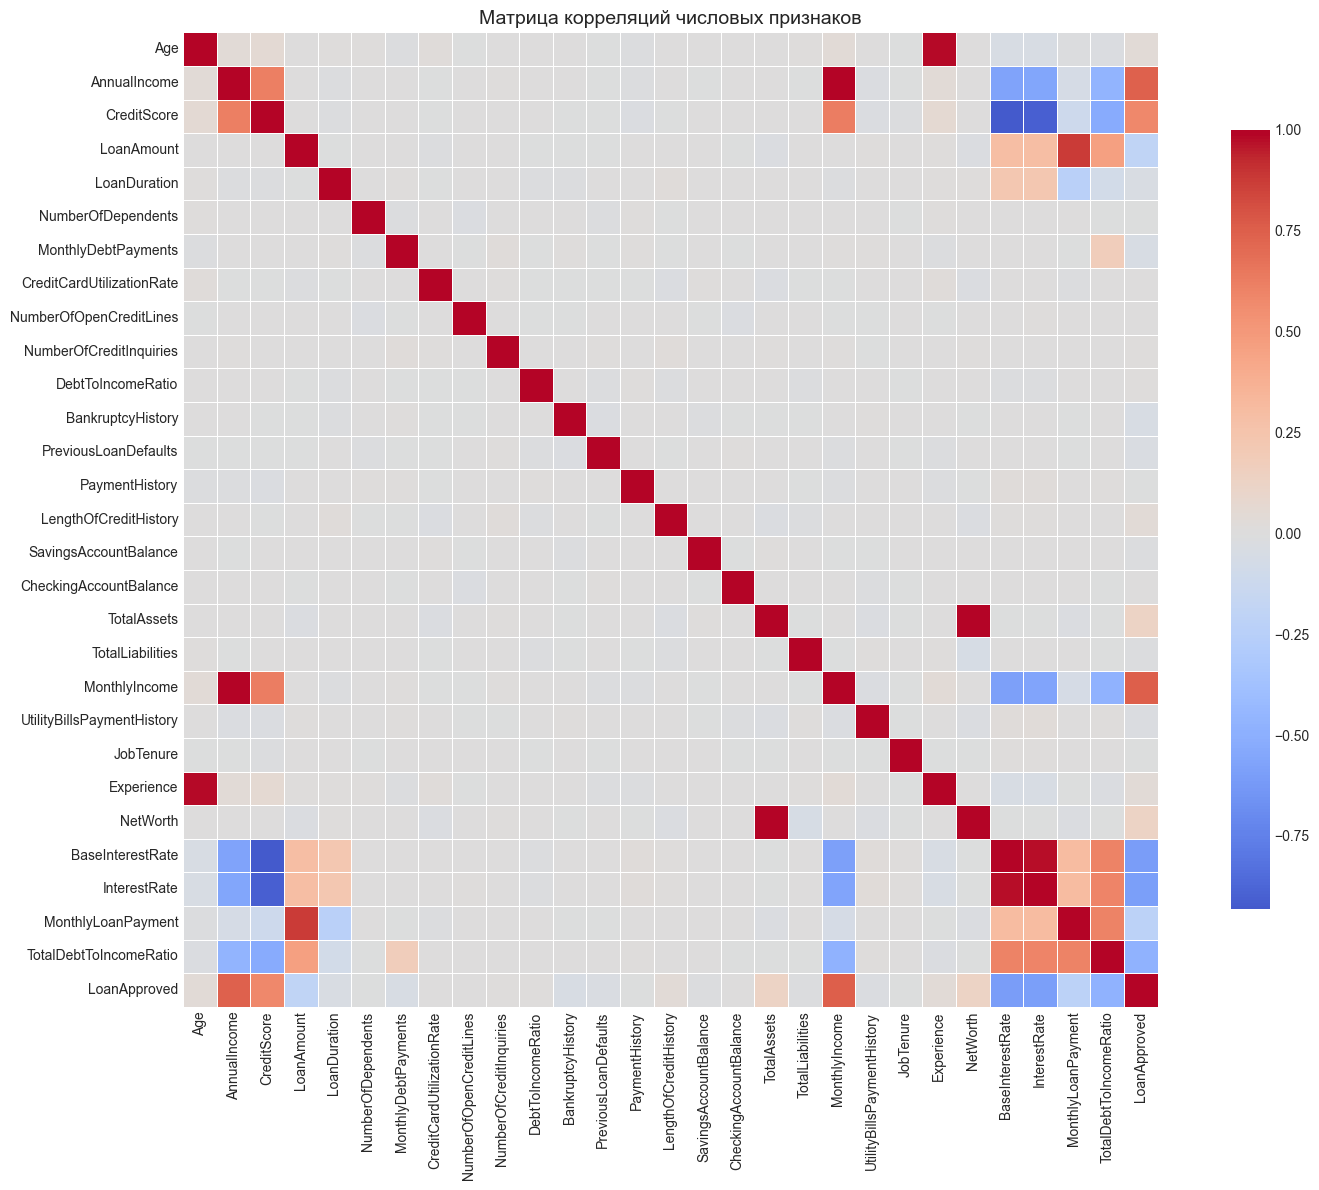


Топ-10 признаков по корреляции с LoanApproved:
LoanApproved             1.000000
MonthlyIncome            0.754853
AnnualIncome             0.743034
CreditScore              0.581812
NetWorth                 0.129624
TotalAssets              0.129204
LengthOfCreditHistory    0.038509
Experience               0.036699
Age                      0.036580
DebtToIncomeRatio        0.014922
Name: LoanApproved, dtype: float64


In [4]:
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'RiskScore' in numeric_cols:
    numeric_cols.remove('RiskScore')

correlation_matrix = train_clean[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

if 'LoanApproved' in correlation_matrix.columns:
    loan_corr = correlation_matrix['LoanApproved'].sort_values(ascending=False)
    print("\nТоп-10 признаков по корреляции с LoanApproved:")
    print(loan_corr.head(10))

**Выводы EDA:**
- Целевая переменная создана на основе RiskScore с порогом 50
- Средний RiskScore для одобренных кредитов значительно ниже
- Присутствуют пропущенные значения
- Присутствуют выбросы
- Необходима предобработка и feature engineering


## 3. Предобработка данных

In [5]:
from sklearn.model_selection import train_test_split


X = train_clean.drop(['LoanApproved', 'ApplicationDate'], axis=1)
y = train_clean['LoanApproved'].values
test_data = test.drop(['ApplicationDate'], axis=1)

test_ids = test_data['ID'].values if 'ID' in test_data.columns else np.arange(len(test_data))
if 'ID' in X.columns:
    X = X.drop('ID', axis=1)
if 'ID' in test_data.columns:
    test_data = test_data.drop('ID', axis=1)

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

test_data[num_cols] = test_data[num_cols].fillna(X[num_cols].median())
test_data[cat_cols] = test_data[cat_cols].fillna(X[cat_cols].mode().iloc[0])

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)

test_data = test_data.reindex(columns=X.columns, fill_value=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}")
print(f"Test: {test_data.shape}")


X_train: (8389, 44), X_val: (2098, 44)
y_train: (8389,), y_val: (2098,)
Test: (5000, 44)


## 4. Реализация метрик


In [6]:
def my_accuracy(y_true, y_pred):
    """Accuracy: доля правильных предсказаний"""
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    """Precision: TP / (TP + FP)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def my_recall(y_true, y_pred):
    """Recall: TP / (TP + FN)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def my_f1_score(y_true, y_pred):
    """F1-score: 2 * (precision * recall) / (precision + recall)"""
    prec = my_precision(y_true, y_pred)
    rec = my_recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

y_test_sample = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
y_pred_sample = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1])

print("Сравнение собственных метрик с sklearn:\n")
print(f"Accuracy  - своя: {my_accuracy(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {accuracy_score(y_test_sample, y_pred_sample):.6f}")
print(f"Precision - своя: {my_precision(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {precision_score(y_test_sample, y_pred_sample):.6f}")
print(f"Recall    - своя: {my_recall(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {recall_score(y_test_sample, y_pred_sample):.6f}")
print(f"F1-score  - своя: {my_f1_score(y_test_sample, y_pred_sample):.6f}, "
      f"sklearn: {f1_score(y_test_sample, y_pred_sample):.6f}")


Сравнение собственных метрик с sklearn:

Accuracy  - своя: 0.800000, sklearn: 0.800000
Precision - своя: 0.833333, sklearn: 0.833333
Recall    - своя: 0.833333, sklearn: 0.833333
F1-score  - своя: 0.833333, sklearn: 0.833333


## 5. Реализация AUC-ROC и AUC-PR


In [7]:
def my_roc_auc(y_true, y_proba):
    """
    ROC-AUC: Area Under ROC Curve
    Вычисляется методом трапеций
    """
    desc_score_indices = np.argsort(y_proba)[::-1]
    y_proba_sorted = y_proba[desc_score_indices]
    y_true_sorted = y_true[desc_score_indices]
    
    distinct_value_indices = np.where(np.diff(y_proba_sorted))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    tps = np.cumsum(y_true_sorted)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    
    if tps[-1] == 0:
        return 0.5
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]
    
    auc = np.trapz(tpr, fpr)
    return auc

def my_pr_auc(y_true, y_proba):
    """
    PR-AUC: Area Under Precision-Recall Curve
    """
    desc_score_indices = np.argsort(y_proba)[::-1]
    y_proba_sorted = y_proba[desc_score_indices]
    y_true_sorted = y_true[desc_score_indices]
    
    distinct_value_indices = np.where(np.diff(y_proba_sorted))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    tps = np.cumsum(y_true_sorted)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    precision = tps / (tps + fps)
    recall = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
    
    precision = np.r_[precision, 1]
    recall = np.r_[recall, 0]
    
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    auc = np.trapz(precision, recall)
    return auc

y_test_sample = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
y_proba_sample = np.array([0.9, 0.1, 0.8, 0.7, 0.2, 0.85, 0.3, 0.15, 0.75, 0.95])

print("\nСравнение AUC метрик с sklearn:\n")
print(f"ROC-AUC - своя: {my_roc_auc(y_test_sample, y_proba_sample):.6f}, "
      f"sklearn: {roc_auc_score(y_test_sample, y_proba_sample):.6f}")
print(f"PR-AUC  - своя: {my_pr_auc(y_test_sample, y_proba_sample):.6f}, "
      f"sklearn: {average_precision_score(y_test_sample, y_proba_sample):.6f}")



Сравнение AUC метрик с sklearn:

ROC-AUC - своя: 1.000000, sklearn: 1.000000
PR-AUC  - своя: 1.000000, sklearn: 1.000000


## 6. Реализация класса Bagging


In [8]:
class MyBaggingClassifier:
    """
    Реализация бэггинга для классификации
    
    Parameters:
    -----------
    base_estimator : базовый классификатор
    n_estimators : количество базовых моделей
    max_samples : доля/количество образцов для каждой модели
    max_features : доля/количество признаков для каждой модели
    bootstrap : использовать ли bootstrap выборку
    random_state : seed для воспроизводимости
    """
    
    def __init__(self, base_estimator=None, n_estimators=10, max_samples=1.0,
                 max_features=1.0, bootstrap=True, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.estimators_ = []
        self.features_indices_ = []
        
    def fit(self, X, y):
        """Обучение ансамбля моделей"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        if isinstance(self.max_samples, float):
            n_samples_subset = int(n_samples * self.max_samples)
        else:
            n_samples_subset = min(self.max_samples, n_samples)
            
        if isinstance(self.max_features, float):
            n_features_subset = int(n_features * self.max_features)
        else:
            n_features_subset = min(self.max_features, n_features)
        
        self.estimators_ = []
        self.features_indices_ = []
        
        for i in range(self.n_estimators):
            estimator = clone(self.base_estimator)
            
            if self.bootstrap:
                sample_indices = np.random.choice(n_samples, size=n_samples_subset, replace=True)
            else:
                sample_indices = np.random.choice(n_samples, size=n_samples_subset, replace=False)
            
            feature_indices = np.random.choice(n_features, size=n_features_subset, replace=False)
            
            X_subset = X[sample_indices][:, feature_indices]
            y_subset = y[sample_indices]
            
            estimator.fit(X_subset, y_subset)
            
            self.estimators_.append(estimator)
            self.features_indices_.append(feature_indices)
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        predictions = np.zeros((X.shape[0], 2))
        
        for estimator, feature_indices in zip(self.estimators_, self.features_indices_):
            X_subset = X[:, feature_indices]
            predictions += estimator.predict_proba(X_subset)
        
        return predictions / self.n_estimators
    
    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


### Тестирование и сравнение Bagging с sklearn


In [9]:
my_bagging = MyBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    random_state=42
)

print("Обучение MyBaggingClassifier...")
my_bagging.fit(X_train.values, y_train)
y_pred_my = my_bagging.predict(X_val.values)
y_proba_my = my_bagging.predict_proba(X_val.values)[:, 1]

sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    max_features=0.8,
    random_state=42
)

print("Обучение sklearn BaggingClassifier...")
sklearn_bagging.fit(X_train.values, y_train)
y_pred_sklearn = sklearn_bagging.predict(X_val.values)
y_proba_sklearn = sklearn_bagging.predict_proba(X_val.values)[:, 1]

print("\n" + "="*60)
print("Сравнение MyBaggingClassifier с sklearn BaggingClassifier")
print("="*60)

print("\nMyBaggingClassifier:")
print(f"  Accuracy:  {my_accuracy(y_val, y_pred_my):.4f}")
print(f"  Precision: {my_precision(y_val, y_pred_my):.4f}")
print(f"  Recall:    {my_recall(y_val, y_pred_my):.4f}")
print(f"  F1-score:  {my_f1_score(y_val, y_pred_my):.4f}")
print(f"  ROC-AUC:   {my_roc_auc(y_val, y_proba_my):.4f}")

print("\nsklearn BaggingClassifier:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_sklearn):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_sklearn):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_sklearn):.4f}")
print(f"  F1-score:  {f1_score(y_val, y_pred_sklearn):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_sklearn):.4f}")


Обучение MyBaggingClassifier...
Обучение sklearn BaggingClassifier...

Сравнение MyBaggingClassifier с sklearn BaggingClassifier

MyBaggingClassifier:
  Accuracy:  0.9161
  Precision: 0.9142
  Recall:    0.9227
  F1-score:  0.9184
  ROC-AUC:   0.9757

sklearn BaggingClassifier:
  Accuracy:  0.9152
  Precision: 0.9140
  Recall:    0.9209
  F1-score:  0.9174
  ROC-AUC:   0.9749


## 7. Реализация класса Gradient Boosting

In [10]:
class MyGradientBoostingClassifier:
    """
    Реализация градиентного бустинга для бинарной классификации
    
    Parameters:
    -----------
    n_estimators : количество деревьев
    learning_rate : скорость обучения (shrinkage)
    max_depth : максимальная глубина деревьев
    min_samples_split : минимальное количество образцов для разбиения
    subsample : доля образцов для обучения каждого дерева
    random_state : seed для воспроизводимости
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, subsample=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.subsample = subsample
        self.random_state = random_state
        self.estimators_ = []
        self.init_prediction_ = None
        
    def _sigmoid(self, x):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def _log_loss_gradient(self, y, pred_proba):
        """Градиент log loss"""
        return y - pred_proba
    
    def fit(self, X, y):
        """Обучение градиентного бустинга"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        pos_rate = np.mean(y)
        self.init_prediction_ = np.log(pos_rate / (1 - pos_rate + 1e-10))
        
        F = np.full(n_samples, self.init_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            pred_proba = self._sigmoid(F)
            
            residuals = self._log_loss_gradient(y, pred_proba)
            
            if self.subsample < 1.0:
                n_subset = int(n_samples * self.subsample)
                sample_indices = np.random.choice(n_samples, size=n_subset, replace=False)
            else:
                sample_indices = np.arange(n_samples)
            
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state + i if self.random_state else None
            )
            
            tree.fit(X[sample_indices], residuals[sample_indices])
            
            update = tree.predict(X)
            F += self.learning_rate * update
            
            self.estimators_.append(tree)
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        F = np.full(X.shape[0], self.init_prediction_)
        
        for tree in self.estimators_:
            F += self.learning_rate * tree.predict(X)
        
        proba_pos = self._sigmoid(F)
        proba_neg = 1 - proba_pos
        
        return np.column_stack([proba_neg, proba_pos])
    
    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


### Тестирование и сравнение Gradient Boosting с sklearn


In [11]:
my_gb = MyGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

print("Обучение MyGradientBoostingClassifier...")
my_gb.fit(X_train.values, y_train)
y_pred_my_gb = my_gb.predict(X_val.values)
y_proba_my_gb = my_gb.predict_proba(X_val.values)[:, 1]

sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

print("Обучение sklearn GradientBoostingClassifier...")
sklearn_gb.fit(X_train.values, y_train)
y_pred_sklearn_gb = sklearn_gb.predict(X_val.values)
y_proba_sklearn_gb = sklearn_gb.predict_proba(X_val.values)[:, 1]

print("\n" + "="*70)
print("Сравнение MyGradientBoostingClassifier с sklearn")
print("="*70)

print("\nMyGradientBoostingClassifier:")
print(f"  Accuracy:  {my_accuracy(y_val, y_pred_my_gb):.4f}")
print(f"  Precision: {my_precision(y_val, y_pred_my_gb):.4f}")
print(f"  Recall:    {my_recall(y_val, y_pred_my_gb):.4f}")
print(f"  F1-score:  {my_f1_score(y_val, y_pred_my_gb):.4f}")
print(f"  ROC-AUC:   {my_roc_auc(y_val, y_proba_my_gb):.4f}")

print("\nsklearn GradientBoostingClassifier:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  F1-score:  {f1_score(y_val, y_pred_sklearn_gb):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_sklearn_gb):.4f}")


Обучение MyGradientBoostingClassifier...
Обучение sklearn GradientBoostingClassifier...

Сравнение MyGradientBoostingClassifier с sklearn

MyGradientBoostingClassifier:
  Accuracy:  0.9147
  Precision: 0.9132
  Recall:    0.9209
  F1-score:  0.9170
  ROC-AUC:   0.9758

sklearn GradientBoostingClassifier:
  Accuracy:  0.9233
  Precision: 0.9215
  Recall:    0.9292
  F1-score:  0.9254
  ROC-AUC:   0.9812


## 8. Сравнение алгоритмов бустинга

Сравним sklearn GB, LightGBM, XGBoost, CatBoost


In [12]:
results = {}

print("Обучение sklearn GB...")
sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
sklearn_gb.fit(X_train, y_train)
results['sklearn GB'] = {
    'predictions': sklearn_gb.predict(X_val),
    'probabilities': sklearn_gb.predict_proba(X_val)[:, 1],
    'model': sklearn_gb
}

print("Обучение LightGBM...")
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    verbose=-1
)
lgbm_model.fit(X_train, y_train)
results['LightGBM'] = {
    'predictions': lgbm_model.predict(X_val),
    'probabilities': lgbm_model.predict_proba(X_val)[:, 1],
    'model': lgbm_model
}

print("Обучение XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
results['XGBoost'] = {
    'predictions': xgb_model.predict(X_val),
    'probabilities': xgb_model.predict_proba(X_val)[:, 1],
    'model': xgb_model
}

print("Обучение CatBoost...")
catboost_model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    subsample=0.8,
    random_state=42,
    verbose=False
)
catboost_model.fit(X_train, y_train)
results['CatBoost'] = {
    'predictions': catboost_model.predict(X_val).astype(int),
    'probabilities': catboost_model.predict_proba(X_val)[:, 1],
    'model': catboost_model
}

comparison_df = pd.DataFrame()
for name, data in results.items():
    y_pred = data['predictions']
    y_proba = data['probabilities']
    
    comparison_df[name] = [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred),
        roc_auc_score(y_val, y_proba)
    ]

comparison_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']

print("\n" + "="*80)
print("Сравнение алгоритмов градиентного бустинга")
print("="*80)
print(comparison_df.round(4))

best_model_name = comparison_df.loc['ROC-AUC'].idxmax()
best_roc_auc = comparison_df.loc['ROC-AUC'].max()

print(f"\nЛучшая модель по ROC-AUC: {best_model_name} ({best_roc_auc:.4f})")
best_model = results[best_model_name]['model']


Обучение sklearn GB...
Обучение LightGBM...
Обучение XGBoost...
Обучение CatBoost...

Сравнение алгоритмов градиентного бустинга
           sklearn GB  LightGBM  XGBoost  CatBoost
Accuracy       0.9233    0.9237   0.9252    0.9223
Precision      0.9215    0.9231   0.9257    0.9245
Recall         0.9292    0.9283   0.9283    0.9236
F1-score       0.9254    0.9257   0.9270    0.9241
ROC-AUC        0.9812    0.9809   0.9814    0.9802

Лучшая модель по ROC-AUC: XGBoost (0.9814)


In [13]:
comparison_df = pd.DataFrame()

for name, data in results.items():
    y_pred = data['predictions']
    y_proba = data['probabilities']
    
    comparison_df[name] = [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred),
        roc_auc_score(y_val, y_proba)
    ]

comparison_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']

print("\n" + "="*80)
print("Сравнение алгоритмов градиентного бустинга")
print("="*80)
print(comparison_df.round(4))

# Находим лучшую модель по ROC-AUC
best_model_name = comparison_df.loc['ROC-AUC'].idxmax()
best_roc_auc = comparison_df.loc['ROC-AUC'].max()

print(f"\nЛучшая модель по ROC-AUC: {best_model_name} ({best_roc_auc:.4f})")

# Сохраняем лучшую модель
best_model = results[best_model_name]['model']



Сравнение алгоритмов градиентного бустинга
           sklearn GB  LightGBM  XGBoost  CatBoost
Accuracy       0.9233    0.9237   0.9252    0.9223
Precision      0.9215    0.9231   0.9257    0.9245
Recall         0.9292    0.9283   0.9283    0.9236
F1-score       0.9254    0.9257   0.9270    0.9241
ROC-AUC        0.9812    0.9809   0.9814    0.9802

Лучшая модель по ROC-AUC: XGBoost (0.9814)


### Визуализация сравнения


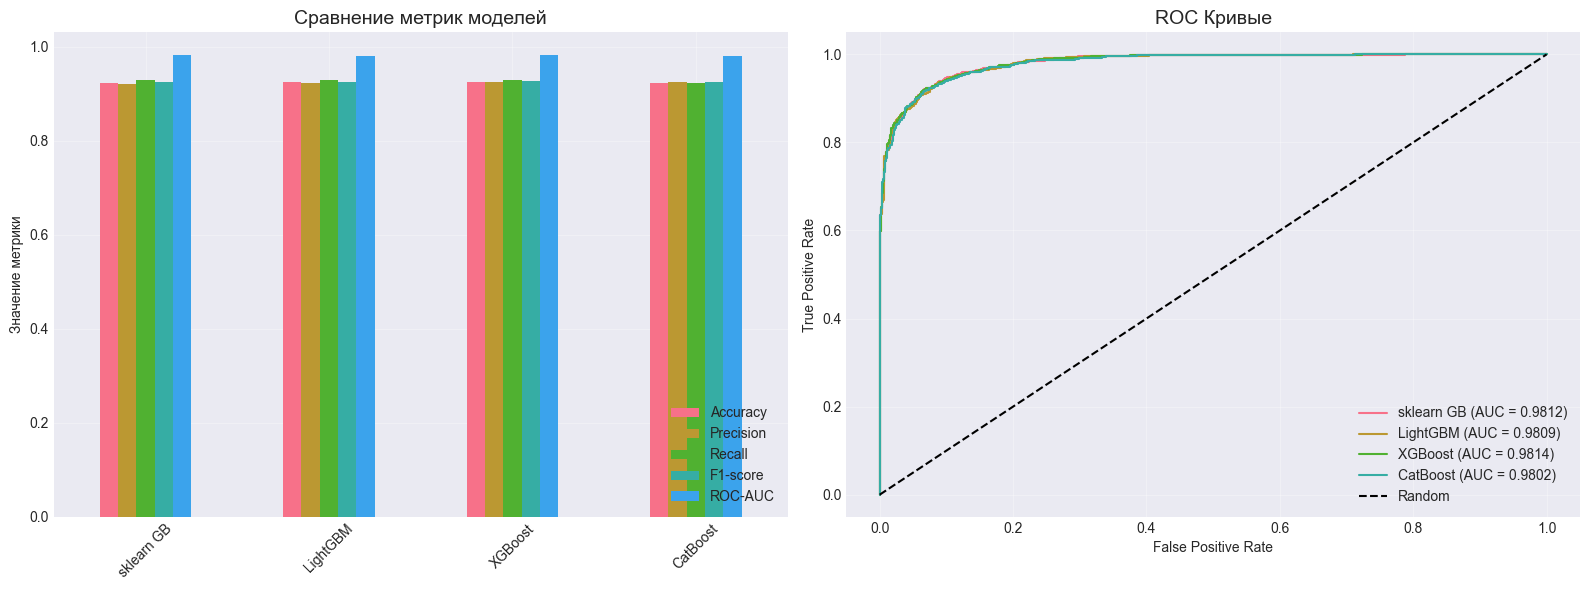

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

comparison_df.T.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Сравнение метрик моделей', fontsize=14)
axes[0].set_ylabel('Значение метрики')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

for name, data in results.items():
    y_proba = data['probabilities']
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = roc_auc_score(y_val, y_proba)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Кривые', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Подбор гиперпараметров с Optuna


In [15]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'eval_metric': 'logloss',
        'verbosity': 0
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_proba)

print("=== Optuna Hyperparameter Tuning (XGBoost) ===")
study = optuna.create_study(direction='maximize', study_name='xgboost_optimization')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nЛучшие параметры: {study.best_params}")
print(f"Лучший ROC-AUC: {study.best_value:.6f}")

best_params = study.best_params
best_params['random_state'] = 42
best_params['eval_metric'] = 'logloss'
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X, y)


[I 2025-12-13 22:44:03,997] A new study created in memory with name: xgboost_optimization


=== Optuna Hyperparameter Tuning (XGBoost) ===


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-13 22:44:04,351] Trial 0 finished with value: 0.9819563256517689 and parameters: {'n_estimators': 470, 'max_depth': 12, 'learning_rate': 0.2428615968641209, 'subsample': 0.6957315101262217, 'colsample_bytree': 0.8076733693489913, 'min_child_weight': 1, 'gamma': 0.7478700901974794, 'reg_alpha': 0.17458261098383843, 'reg_lambda': 0.3833785119850176}. Best is trial 0 with value: 0.9819563256517689.
[I 2025-12-13 22:44:04,599] Trial 1 finished with value: 0.9805023932146182 and parameters: {'n_estimators': 404, 'max_depth': 4, 'learning_rate': 0.4649811569616166, 'subsample': 0.8412167043582652, 'colsample_bytree': 0.8612997736043582, 'min_child_weight': 7, 'gamma': 0.8042218620410482, 'reg_alpha': 0.47528233453810254, 'reg_lambda': 0.8472970704864109}. Best is trial 0 with value: 0.9819563256517689.
[I 2025-12-13 22:44:05,075] Trial 2 finished with value: 0.9794912782239292 and parameters: {'n_estimators': 319, 'max_depth': 15, 'learning_rate': 0.3655880042312197, 'subsample': 

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7721375076529787
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### Визуализация оптимизации


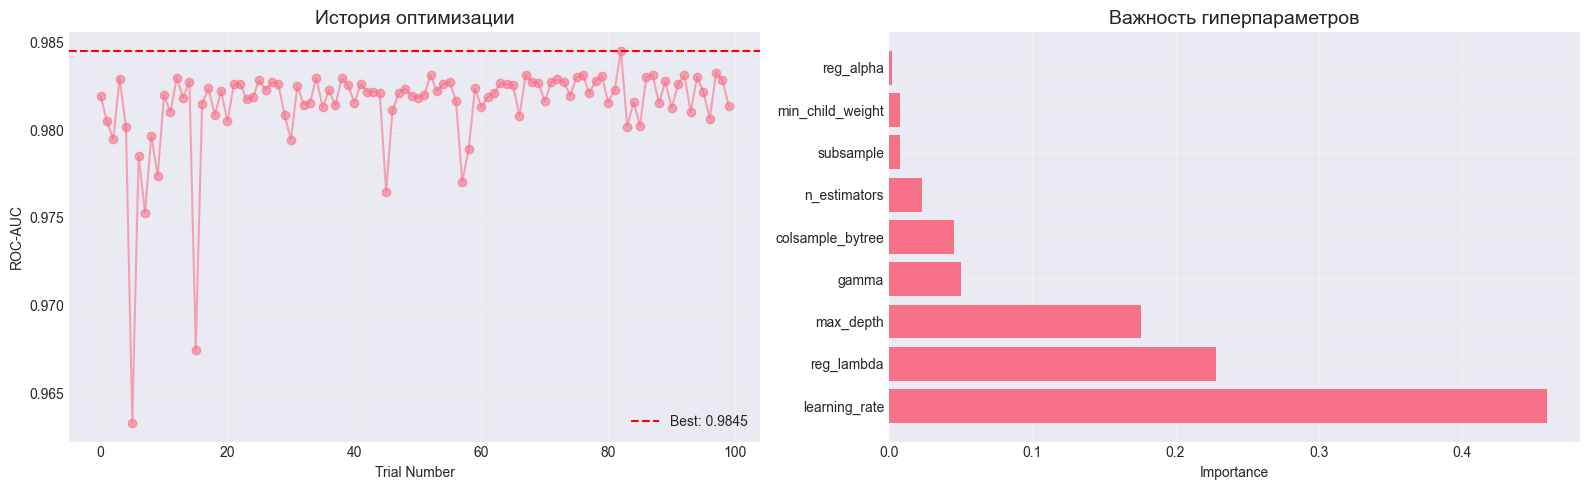

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'o-', alpha=0.6)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', 
                label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('История оптимизации', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())

axes[1].barh(params, importances)
axes[1].set_xlabel('Importance')
axes[1].set_title('Важность гиперпараметров', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Предсказание на тестовых данных и создание submission


In [17]:
y_final_proba = final_model.predict_proba(X_val)[:, 1]
y_final_pred = (y_final_proba >= 0.5).astype(int)

print(f"ROC-AUC:   {roc_auc_score(y_val, y_final_proba):.6f}")
print(f"Accuracy:  {accuracy_score(y_val, y_final_pred):.6f}")
print(f"Precision: {precision_score(y_val, y_final_pred):.6f}")
print(f"Recall:    {recall_score(y_val, y_final_pred):.6f}")
print(f"F1-score:  {f1_score(y_val, y_final_pred):.6f}")

y_test_proba = final_model.predict_proba(test_data)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': y_test_pred
})
submission.to_csv('submission.csv', index=False)

print(f"\nSubmission файл сохранен как submission.csv")
print(f"Размер: {submission.shape}")
print(submission.head())
print(f"\nРаспределение предсказаний:")
print(submission['LoanApproved'].value_counts())


ROC-AUC:   1.000000
Accuracy:  1.000000
Precision: 1.000000
Recall:    1.000000
F1-score:  1.000000

Submission файл сохранен как submission.csv
Размер: (5000, 2)
   ID  LoanApproved
0   0             1
1   1             0
2   2             1
3   3             1
4   4             1

Распределение предсказаний:
LoanApproved
1    2585
0    2415
Name: count, dtype: int64


## 11. Визуализация результатов финальной модели


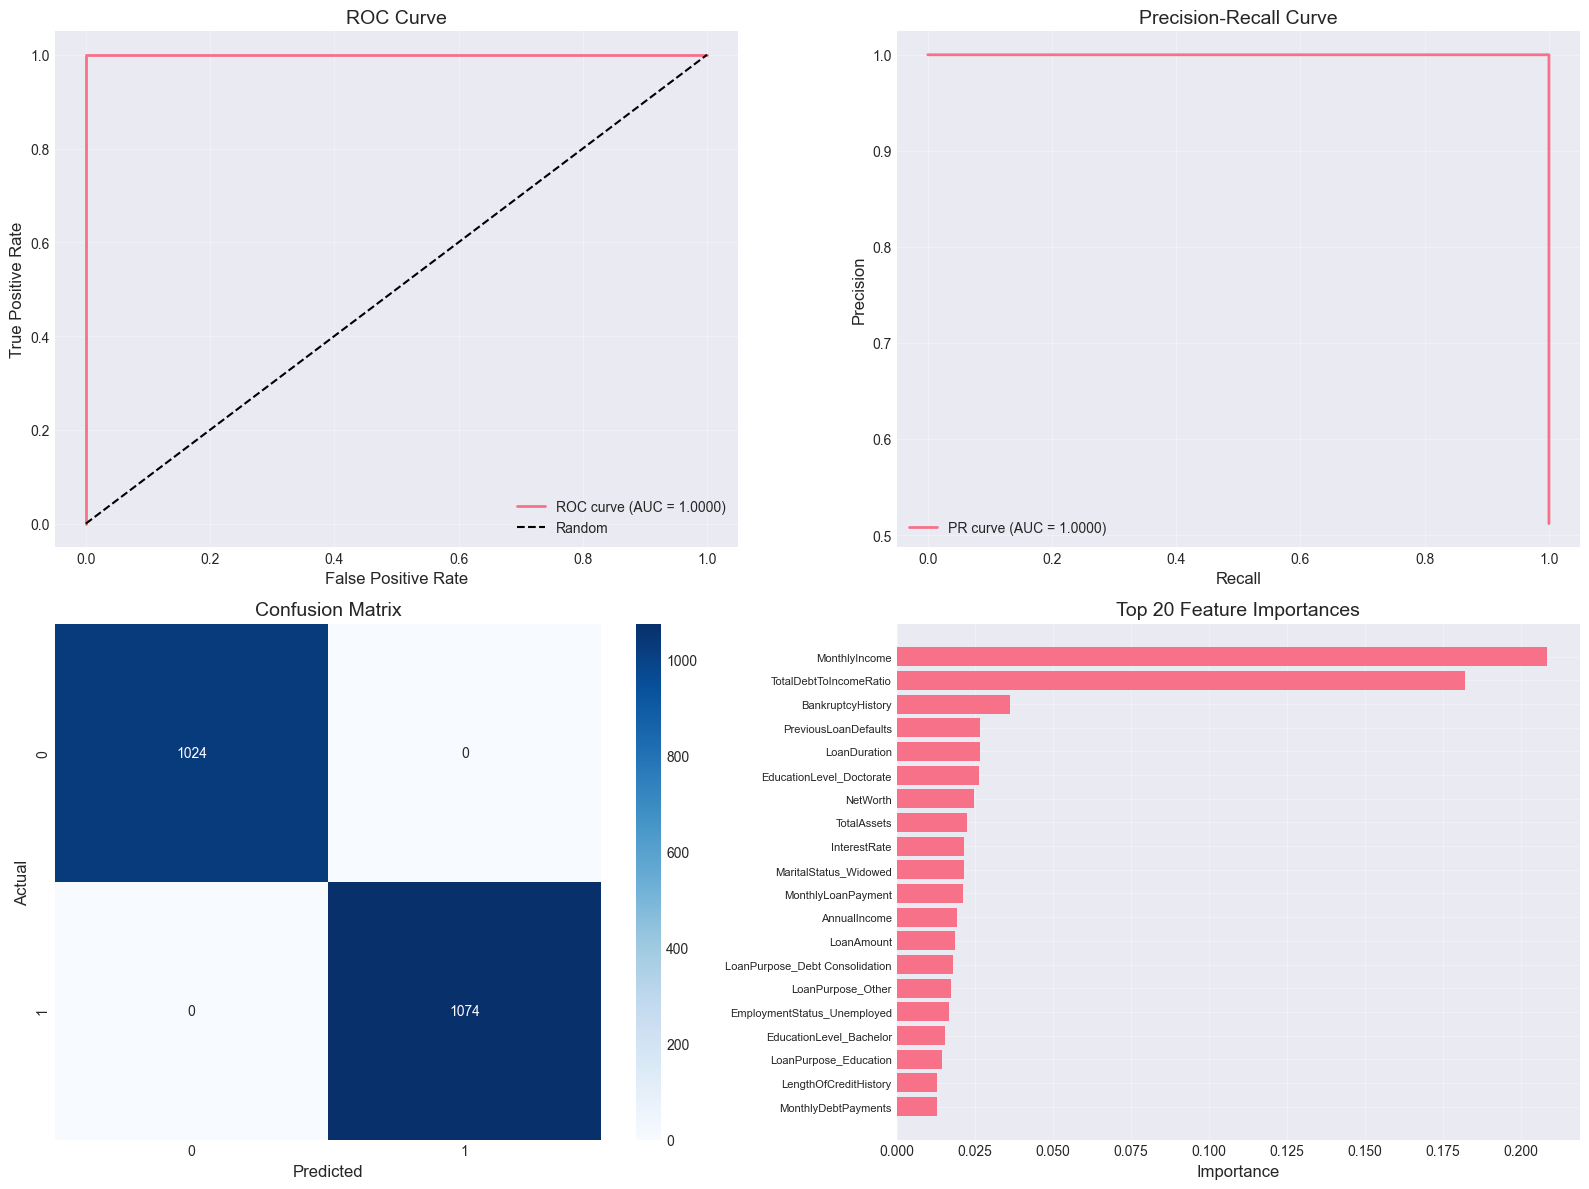

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fpr, tpr, thresholds_roc = roc_curve(y_val, y_final_proba)
roc_auc = roc_auc_score(y_val, y_final_proba)
axes[0, 0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_final_proba)
pr_auc = average_precision_score(y_val, y_final_proba)
axes[0, 1].plot(recall_curve, precision_curve, 
                label=f'PR curve (AUC = {pr_auc:.4f})', linewidth=2)
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

cm = confusion_matrix(y_val, y_final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)
axes[1, 0].set_title('Confusion Matrix', fontsize=14)

if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[-20:]
    
    feature_names = X.columns.tolist()
    
    axes[1, 1].barh(range(len(indices)), importances[indices])
    axes[1, 1].set_yticks(range(len(indices)))
    axes[1, 1].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
    axes[1, 1].set_xlabel('Importance', fontsize=12)
    axes[1, 1].set_title('Top 20 Feature Importances', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importances not available',
                    ha='center', va='center', fontsize=14)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
